In [43]:
import pandas as pd
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import glob
from tqdm import tqdm_notebook
import gc
import ntpath
import os
import random
from data import *
import math

In [ ]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

def get_id_by_path(path):
    return cat2id[path_leaf(path)[:-4]]

In [ ]:
def get_color_from_lst(lst, maxlight = True):
    min_value = min(lst)
    max_value = max(lst)
    colors = []
    for value in lst:
        if max_value == min_value:
            color = 255
        else:
            if maxlight == False:
                color = int((max_value - value) / (max_value - min_value) * 200 + 55)
            else:
                color = int((value - min_value) / (max_value - min_value) * 200 + 55)
        colors.append(color)
    return colors

def get_scale_simple(stroke, pad = 5):
    maxx = max([max(s[0]) for s in stroke])
    maxy = max([max(s[1]) for s in stroke])
    minx = min([min(s[0]) for s in stroke])
    miny = min([min(s[1]) for s in stroke])

    width = maxx - minx
    height = maxy - miny
#     print(width, height)
    scale = BASE_SIZE / (width + 2 * pad) if width > height else BASE_SIZE / (height + 2 * pad)
    return scale, minx, miny

def draw_time_encoding(stroke, size=256, lw = 2):
    BASE_SIZE = 256
    pad = 5
    timestamp = []
    draw_time = []
    pause_time = []
    for idx,s in enumerate(stroke):
        timestamp.append(s[2][0])
        draw_time.append(s[2][-1] - s[2][0])
        if idx > 0:
            pause_time.append(stroke[idx][2][0] - stroke[idx-1][2][-1])
    if len(pause_time) > 0:
        pause_time = [min(pause_time)] + pause_time     
    else:
        pause_time = [0]

    drawtime_color = get_color_from_lst(draw_time)
    pausetime_color = get_color_from_lst(pause_time)
    timestamp_color = get_color_from_lst(timestamp, maxlight=False)
    
    scale, minx, miny = get_scale_simple(stroke, pad)
    
    img = np.zeros((BASE_SIZE, BASE_SIZE, 3), np.uint8)
    stroke_num = len(stroke)
    for idx,s in enumerate(stroke):
        time_start_color = timestamp_color[idx]
        if idx == stroke_num - 1:
            time_end_color = 55
        else:
            time_end_color = timestamp_color[idx + 1]
            
        ptr_num = len(s[0])
        for i in range(ptr_num - 1):
            x0 = int((s[0][i] - minx + pad) * scale)
            y0 = int((s[1][i] - miny + pad) * scale)
            x1 = int((s[0][i+1] - minx + pad) * scale)
            y1 = int((s[1][i + 1] - miny + pad) * scale)
            
            ratio = i / ptr_num
            timecolor = int(time_start_color * (1 - ratio) + time_end_color * ratio)
            color = (timecolor, drawtime_color[idx], pausetime_color[idx])
            cv2.line(img, (x0, y0), (x1, y1), color, lw)
    
    if size != BASE_SIZE:
        img = cv2.resize(img, (size, size))
    return img

In [ ]:

def image_detail_generator(size, batchsize, lw = 6, preprocess_input = None):

    np_classes = np.load('../input/classes.npy')
    cat2id = {cat.replace(' ', '_'):k for k, cat in enumerate(np_classes)}

    files = glob.glob('../input/train_raw/*.csv')

    readers = []
    for f in files:
        readers.append(pd.read_csv(f, chunksize=1))

    while True:
        x = np.zeros((batchsize, size, size, 3), dtype=np.uint8)
        y = np.zeros(batchsize, dtype=np.uint32)
        for i in range(batchsize):
            idx = random.randint(0, len(readers) - 1)
            line = next(readers[idx])
            stroke = json.loads(line['drawing'].values[0])
            img = draw_time_encoding(stroke, size=size, lw=lw)

            id = cat2id[line['word'].values[0].replace(' ', '_')]
            x[i,...] = img
            y[i] = id
            
        if preprocess_input is not None:
            x = preprocess_input(x.astype(np.float32)).astype(np.float32)
        y = keras.utils.to_categorical(y, num_classes=NCATS)
        
        yield x, y

In [2]:
gen = image_detail_generator_temp(71, 16, draw_drawtime_parts, lw = 6)

gen inited


<Figure size 432x288 with 0 Axes>

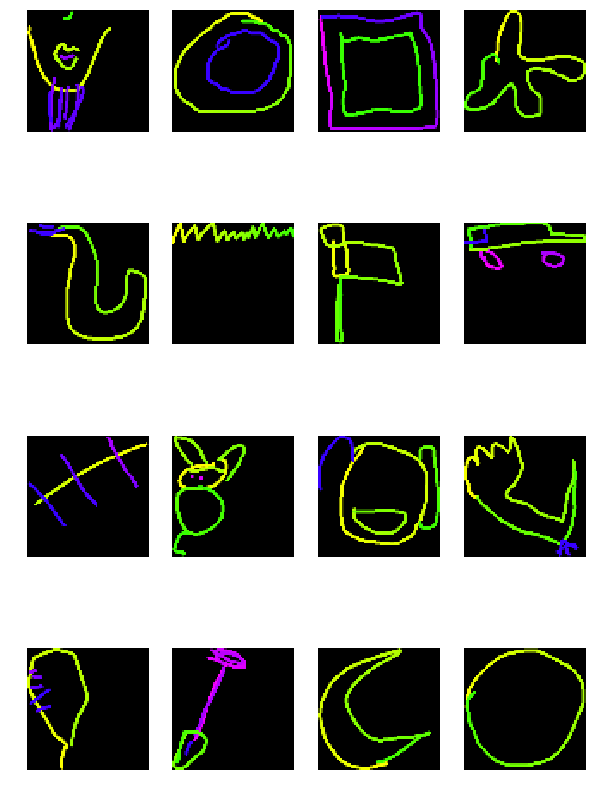

CPU times: user 812 ms, sys: 824 ms, total: 1.64 s
Wall time: 1.09 s


In [3]:
%%time
x, y = next(gen)
plotDoodles(x)

In [ ]:
df = pd.read_csv('../input/train_raw/airplane.csv', nrows=100)


In [ ]:
df.head()

In [ ]:
stroke = json.loads(df.iloc[4]['drawing'])

In [ ]:
def draw_drawtime_parts(stroke, size=256, lw = 2):
    BASE_SIZE = 256
    pad = 5
    timestamp = []
    draw_time = []
    for idx,s in enumerate(stroke):
        timestamp.append(s[2][0])
        draw_time.append(s[2][-1] - s[2][0])
    
    if len(stroke) > 1:
        log_draw_time = [math.log1p(t) for t in draw_time]
        X = np.array(log_draw_time).reshape(-1,1)
        kmeans = KMeans(n_clusters=2)
        kmeans.fit(X)
        y_kmeans = kmeans.predict(X)
        draw_type = list(y_kmeans)

        drawtime0 = []
        drawtime1 = []
        for idx,tag in enumerate(draw_type):
            if tag == 0:
                drawtime0.append(draw_time[idx])
            else:
                drawtime1.append(draw_time[idx])
        mean0 = np.mean(drawtime0)
        mean1 = np.mean(drawtime1)

        if mean0 > mean1:
            outline = 0
            detail = 1
        else:
            outline = 1
            detail = 0
    else:
        draw_type = [0]
        outline = 0
        detail = 1

    timestamp_color = get_color_from_lst(timestamp, maxlight=False)
    scale, minx, miny = get_scale_simple(stroke, pad)

    img = np.zeros((BASE_SIZE, BASE_SIZE, 3), np.uint8)
    stroke_num = len(stroke)
    for idx,s in enumerate(stroke):
        time_start_color = timestamp_color[idx]
        if idx == stroke_num - 1:
            time_end_color = 55
        else:
            time_end_color = timestamp_color[idx + 1]

        ptr_num = len(s[0])
        for i in range(ptr_num - 1):
            x0 = int((s[0][i] - minx + pad) * scale)
            y0 = int((s[1][i] - miny + pad) * scale)
            x1 = int((s[0][i+1] - minx + pad) * scale)
            y1 = int((s[1][i + 1] - miny + pad) * scale)

            ratio = i / ptr_num
            timecolor = int(time_start_color * (1 - ratio) + time_end_color * ratio)
            color = (timecolor, 
                     255 if draw_type[idx] == outline else 0, 
                     255 if draw_type[idx] == detail else 0)
            cv2.line(img, (x0, y0), (x1, y1), color, lw)
            
    if size != BASE_SIZE:
        img = cv2.resize(img, (size, size))
        
    return img

In [ ]:
stroke = json.loads(df.iloc[28]['drawing'])
plt.imshow(draw_drawtime_parts(stroke, lw=2))

In [ ]:
detail

In [ ]:
def draw_drawtime_parts(stroke, size=256, lw = 2):
    BASE_SIZE = 256
    pad = 5
    timestamp = []
    draw_time = []
    pause_time = []
    for idx,s in enumerate(stroke):
        timestamp.append(s[2][0])
        draw_time.append(s[2][-1] - s[2][0])
        if idx > 0:
            pause_time.append(stroke[idx][2][0] - stroke[idx-1][2][-1])
    if len(pause_time) > 0:
        pause_time = [min(pause_time)] + pause_time     
    else:
        pause_time = [0]

    if len(draw_time) > 1:
        X = np.array(draw_time).reshape(-1,1)
        kmeans = KMeans(n_clusters=2)
        kmeans.fit(X)
        y_kmeans = kmeans.predict(X)
        draw_type = list(y_kmeans)

    drawtime_color = get_color_from_lst(draw_time)
    pausetime_color = get_color_from_lst(pause_time)
    timestamp_color = get_color_from_lst(timestamp, maxlight=False)
    
    scale, minx, miny = get_scale_simple(stroke, pad)
    
    img = np.zeros((BASE_SIZE, BASE_SIZE, 3), np.uint8)
    stroke_num = len(stroke)
    for idx,s in enumerate(stroke):
        time_start_color = timestamp_color[idx]
        if idx == stroke_num - 1:
            time_end_color = 55
        else:
            time_end_color = timestamp_color[idx + 1]
            
        ptr_num = len(s[0])
        for i in range(ptr_num - 1):
            x0 = int((s[0][i] - minx + pad) * scale)
            y0 = int((s[1][i] - miny + pad) * scale)
            x1 = int((s[0][i+1] - minx + pad) * scale)
            y1 = int((s[1][i + 1] - miny + pad) * scale)
            
            ratio = i / ptr_num
            timecolor = int(time_start_color * (1 - ratio) + time_end_color * ratio)
            color = (timecolor, drawtime_color[idx], pausetime_color[idx])
            cv2.line(img, (x0, y0), (x1, y1), color, lw)
    
    if size != BASE_SIZE:
        img = cv2.resize(img, (size, size))
    return img

In [ ]:
img = draw_time_encoding(stroke)
# 

In [ ]:
plt.imshow(img)

In [ ]:
plt.imshow(img)

In [ ]:
%%time
get_scale_simple(stroke)

In [ ]:
valid_path = '../input/valid_raw.csv'
if os.path.exists(valid_path):
    df_valid_total = pd.read_csv(valid_path)
else:
    df_valid_total = pd.DataFrame(columns=['drawing','word'])
for idx, file in tqdm_notebook(enumerate(files)):
    
    if path_leaf(file)[:-4] in df_valid_total.word.unique():
        print('skip', file)
        continue
    
    df = pd.read_csv(file)
    valdf = df[-100:][['drawing','word']]
    df_valid_total = df_valid_total.append(valdf, ignore_index=True)
    df = df[:-100]
    df.to_csv(file, index = False)
    del df
    gc.collect()
    
    df_valid_total.to_csv('../input/valid_raw.csv', index=False)
#     if idx > 5:
#         break


In [ ]:
df_valid_total.shape

In [ ]:
df_valid_total.word.unique()

In [ ]:
raw = pd.read_csv('../input/train_raw/angel.csv')
raw.shape

In [ ]:
raw[-100:].shape

In [ ]:
tmp = raw.iloc[0]

In [ ]:
tmp = tmp.drawing

In [ ]:
pause_time = []
for i in range(1,len(stroke)):
    pause_time.append(stroke[i][2][0] - stroke[i-1][2][-1])
pause_time = [min(pause_time)] + pause_time
    
X = np.array(pause_time[1:]).reshape(-1,1)
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
pause_type = [0] + list(y_kmeans)

In [ ]:
pause_time

In [ ]:
draw_time = []
for s in stroke:
    draw_time.append(s[2][-1] - s[2][0])
    
X = np.array(draw_time).reshape(-1,1)
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
draw_type = list(y_kmeans)

In [ ]:
timestamp = []
for s in stroke:
    timestamp.append(s[2][0])
max_timestamp = max(timestamp)

In [ ]:
len(stroke)

In [ ]:
stroke = json.loads(raw.iloc[14].drawing)
img = draw_time_encoding(stroke)
fig, axs = plt.subplots(1,4,figsize=(10,15))
axs[0].imshow(img)
axs[1].imshow(img[...,0].squeeze())
axs[2].imshow(img[...,1].squeeze())
axs[3].imshow(img[...,2].squeeze())

In [ ]:
img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)

In [ ]:
cv2.line(img, (0, 0), (100, 100), 255, 2)

In [ ]:
drawtime_color = get_color_from_lst(draw_time)
pausetime_color = get_color_from_lst(pause_time)
timestamp_color = get_color_from_lst(timestamp, maxlight=False)

In [ ]:
BASE_SIZE = 256

minx = np.inf
maxx = -np.inf
miny = np.inf
maxy = -np.inf
for s in stroke:
    mx = max(s[0])
    ix = min(s[0])
    my = max(s[1])
    iy = min(s[1])
    
    maxx = mx if mx > maxx else maxx
    minx = ix if ix < minx else minx
    maxy = my if my > maxy else maxy
    miny = iy if iy < miny else miny
print(minx, maxx, miny, maxy)

width = maxx - minx
height = maxy - miny
print(width, height)

if width > height:
    scale = BASE_SIZE / (width + 2 * pad)
else:
    scale = BASE_SIZE / (height + 2 * pad)
print(scale)

pad = 5
lw = 2
img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
for idx,s in enumerate(stroke):
#     color = 255 if draw_type[idx] == 0 else 50
    color = pausetime_color[idx]
    for i in range(len(s[0]) - 1):
        x0 = int((s[0][i] - minx + pad) * scale)
        y0 = int((s[1][i] - miny + pad) * scale)
        x1 = int((s[0][i+1] - minx + pad) * scale)
        y1 = int((s[1][i + 1] - miny + pad) * scale)
        cv2.line(img, (x0, y0),
                 (x1, y1), color, lw)
    
plt.imshow(img)

In [ ]:
df_valid_total.shape

In [ ]:
def df_to_image_array_timeencoding(df, size, lw=6, preprocess_input = None):
    df['drawing'] = df['drawing'].apply(json.loads)
    x = np.zeros((len(df), size, size, 3 ), dtype=np.uint8)
    for i, raw_strokes in enumerate(df.drawing.values):
        img = draw_time_encoding(raw_strokes, size=size, lw=lw)
        x[i, ...] = img
    if preprocess_input is not None:
        print('x shape',x.shape, 'x max', x.max())
        x = preprocess_input(x.astype(np.float32)).astype(np.float32)
    return x 

In [ ]:
val_x = df_to_image_array_timeencoding(df_valid_total, 71, lw = 6)

In [ ]:
valid_df = pd.read_csv('../input/valid_raw.csv')
np_classes = np.load('../input/classes.npy')
cat2id = {cat.replace(' ', '_'):k for k, cat in enumerate(np_classes)}
valid_df.word = valid_df.word.apply(lambda x: cat2id[x.replace(' ', '_')])
y_valid = keras.utils.to_categorical(valid_df.word, num_classes=NCATS)

In [ ]:
y_valid.shape

In [75]:
def angle_between(v1, v2):
    import math
    v1_theta = math.atan2(v1[1], v1[0])
    v2_theta = math.atan2(v2[1], v2[0])
    return (v2_theta - v1_theta) * (180.0 / math.pi)

In [8]:
val_df = pd.read_csv('../input/valid.csv', nrows=10)

In [ ]:
val_df.iloc[1]['drawing']

In [241]:
%%time
for i in range(100):
    _stack_it(val_df.iloc[1]['drawing'])

CPU times: user 280 ms, sys: 0 ns, total: 280 ms
Wall time: 277 ms


In [242]:
%%time
for i in range(100):
    _stack_it_opt(val_df.iloc[1]['drawing'])

CPU times: user 48 ms, sys: 0 ns, total: 48 ms
Wall time: 48.6 ms


In [181]:
_stack_it8_new(val_df.iloc[1]['drawing'])

array([[ 124,   78,    0,    1,    2,    0,  379,    0,    0],
       [  62,   69,    0,    1,    1,   62,  379,    0,   62],
       [  40,   72, -343,    1,    1,   22,  379, -343,   84],
       [  24,   79,   15,    1,    1,   17,  379, -328,  101],
       [   5,   99,   22,    1,    1,   27,  379, -306,  128],
       [   0,  118,   28,    1,    1,   19,  379, -278,  147],
       [   8,  135,   39,    1,    1,   18,  379, -239,  165],
       [  31,  148,   35,    1,    1,   26,  379, -204,  191],
       [  57,  152,   20,    1,    1,   26,  379, -184,  217],
       [  94,  152,    8,    1,    1,   37,  379, -176,  254],
       [ 117,  146,   14,    1,    1,   23,  379, -162,  277],
       [ 132,  138,   13,    1,    1,   17,  379, -149,  294],
       [ 146,  117,   28,    1,    1,   25,  379, -121,  319],
       [ 145,   99,   36,    1,    1,   18,  379,  -85,  337],
       [ 132,   83,   35,    1,    1,   20,  379,  -50,  357],
       [ 111,   75,   30,    1,    1,   22,  379,  -20,

In [122]:
stroke_vec = json.loads(val_df.iloc[1]['drawing'])

In [238]:
def _stack_it(raw_strokes):
    """preprocess the string and make 
    a standard Nx3 stroke vector"""
    stroke_vec = json.loads(raw_strokes) # string->list

    # unwrap the list
    in_strokes = [(xi,yi,i) for i,(x,y) in enumerate(stroke_vec) for xi,yi in zip(x,y)]
    c_strokes = np.stack(in_strokes)
    
    # replace stroke id with 1 for continue, 2 for new
    c_strokes[:,2] += 1 # since 0 is no stroke
    new_flag = np.array([1]+np.diff(c_strokes[:,2]).tolist()) + 1

    # calc distance 
    x_diff = [0] + np.diff(c_strokes[:,0]).tolist()
    y_diff = [0] + np.diff(c_strokes[:,1]).tolist()
    distance = np.sqrt(np.power(x_diff, 2) + np.power(y_diff, 2)).astype(np.uint32)
    
    # calc length for one stroke
    length = np.bincount(c_strokes[:,2], weights=distance).astype(np.uint32)
    leng = np.zeros_like(distance)
    for i in range(1, len(length)):
        leng[c_strokes[:,2] == i] = length[i]
    
    c_strokes = np.column_stack((c_strokes, new_flag, distance, leng))
    c_strokes[c_strokes[:,3] == 2,4] = 0
    
#     length_cumsum = intervaled_cumsum(c_strokes[:,5],c_strokes[:,4])
    df = pd.DataFrame(c_strokes[:,[2,4]])
    len_cumsum = df.groupby(df.iloc[:,0]).agg('cumsum').iloc[:,1].values
    c_strokes = np.column_stack((c_strokes, len_cumsum))

    # pad the strokes with zeros
    return c_strokes

def _stack_it_opt(raw_strokes):
    """preprocess the string and make 
    a standard Nx3 stroke vector"""
    stroke_vec = json.loads(raw_strokes) # string->list

    # unwrap the list
    in_strokes = [(xi,yi,i) for i,(x,y) in enumerate(stroke_vec) for xi,yi in zip(x,y)]
    c_strokes = np.stack(in_strokes)
    
    # replace stroke id with 1 for continue, 2 for new
    c_strokes[:,2] += 1 # since 0 is no stroke
    new_flag = np.array([1]+np.diff(c_strokes[:,2]).tolist()) + 1

    # calc distance 
    x_diff = [0] + np.diff(c_strokes[:,0]).tolist()
    y_diff = [0] + np.diff(c_strokes[:,1]).tolist()
    distance = np.sqrt(np.power(x_diff, 2) + np.power(y_diff, 2)).astype(np.uint32)
    
    # calc length for one stroke
    length = np.bincount(c_strokes[:,2], weights=distance).astype(np.uint32)
    leng = np.zeros_like(distance)
    for i in range(1, len(length)):
        leng[c_strokes[:,2] == i] = length[i]
    
    c_strokes = np.column_stack((c_strokes, new_flag, distance, leng))
    c_strokes[c_strokes[:,3] == 2,4] = 0
    
    len_cumsum = intervaled_cumsum(c_strokes[:,4],c_strokes[:,2])
#     df = pd.DataFrame(c_strokes[:,[2,4]])
#     len_cumsum = df.groupby(df.iloc[:,0]).agg('cumsum').iloc[:,1].values
    c_strokes = np.column_stack((c_strokes, len_cumsum))

    # pad the strokes with zeros
    return c_strokes

In [239]:
_stack_it(val_df.iloc[1]['drawing'])[:10]

array([[124,  78,   1,   2,   0, 379,   0],
       [ 62,  69,   1,   1,  62, 379,  62],
       [ 40,  72,   1,   1,  22, 379,  84],
       [ 24,  79,   1,   1,  17, 379, 101],
       [  5,  99,   1,   1,  27, 379, 128],
       [  0, 118,   1,   1,  19, 379, 147],
       [  8, 135,   1,   1,  18, 379, 165],
       [ 31, 148,   1,   1,  26, 379, 191],
       [ 57, 152,   1,   1,  26, 379, 217],
       [ 94, 152,   1,   1,  37, 379, 254]])

In [240]:
_stack_it_opt(val_df.iloc[1]['drawing'])[:10]

array([[124,  78,   1,   2,   0, 379,   0],
       [ 62,  69,   1,   1,  62, 379,  62],
       [ 40,  72,   1,   1,  22, 379,  84],
       [ 24,  79,   1,   1,  17, 379, 101],
       [  5,  99,   1,   1,  27, 379, 128],
       [  0, 118,   1,   1,  19, 379, 147],
       [  8, 135,   1,   1,  18, 379, 165],
       [ 31, 148,   1,   1,  26, 379, 191],
       [ 57, 152,   1,   1,  26, 379, 217],
       [ 94, 152,   1,   1,  37, 379, 254]])